<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Jacobi method

## Contents

In this notebook, we will learn

- How to paralleize the Jacobi method
- How the data partition can impact the performance of a distributed algorithm
- How to use latency hiding to improve parallel performance



<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to run the next cell before you start studying this notebook. 
</div>

In [ ]:
using Printf

function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
gauss_seidel_1_check(answer) = answer_checker(answer,"c")
jacobi_1_check(answer) = answer_checker(answer, "d")
jacobi_2_check(answer) = answer_checker(answer, "b")
jacobi_3_check(answer) = answer_checker(answer, "c")
println("🥳 Well done! ")

## The Jacobi method for the Laplace equation


The [Jacobi method](https://en.wikipedia.org/wiki/Jacobi_method) is a numerical tool to solve systems of linear algebraic equations. One of the main applications of the Jacobi method is to solve the equations resulting from boundary value problems (BVPs). I.e., given the values at the boundary (of a grid), we are interested in finding the interior values that fulfill a certain equation.



<div>
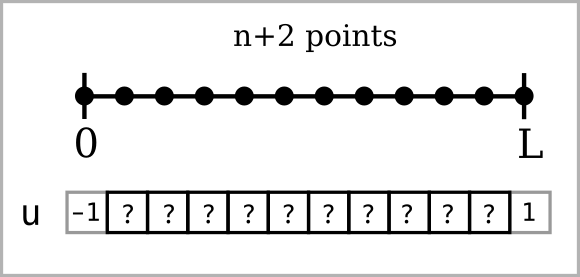
</div>

When solving a [Laplace equation](https://en.wikipedia.org/wiki/Laplace%27s_equation) in 1D, the Jacobi method leads to the following iterative scheme: The entry $i$ of vector $u$ at iteration $t+1$ is computed as:

$u^{t+1}_i = \dfrac{u^t_{i-1}+u^t_{i+1}}{2}$


This iterative is yet simple but shares fundamental challenges with many other algorithms used in scientific computing. This is why we are studying it here.


### Serial implementation

The following code implements the iterative scheme above for boundary conditions -1 and 1 on a grid with $n$ interior points.

In [ ]:
function jacobi(n,niters)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    u_new = copy(u)
    for t in 1:niters
        for i in 2:(n+1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u, u_new = u_new, u
    end
    u
end

If you run it for zero iterations, we will see the initial condition.

In [ ]:
jacobi(5,0)

If you run it for enough iterations, you will see the expected solution of the Laplace equation: values that vary linearly form -1 to 1.

In [ ]:
jacobi(5,100)

In our version of the jacobi method, we return after a given number of iterations. Other stopping criteria are possible. For instance, iterate until the difference between u and u_new is below a tolerance:

In [ ]:
using LinearAlgebra: norm
function jacobi_with_tol(n,tol)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    u_new = copy(u)
    increment = similar(u)
    while true
        for i in 2:(n+1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        increment .= u_new .- u
        if norm(increment)/norm(u_new) < tol
            return u_new
        end
        u, u_new = u_new, u
    end
    u
end

In [ ]:
n = 5
tol = 1e-9
jacobi_with_tol(n,tol)

However, we are not going to parallelize this more complex in this notebook (we will consider it later in this course).


## Where can we exploit parallelism?

Look at the two nested loops in the sequential implementation:

```julia
for t in 1:nsteps
    for i in 2:(n+1)
        u_new[i] = 0.5*(u[i-1]+u[i+1])
    end
    u, u_new = u_new, u
end
```

- The outer loop over `t` cannot be parallelized. The value of `u` at step `t+1` depends on the value at the previous step `t`.
- The inner loop is trivially parallel. The loop iterations are independent (any order is possible).



### The Gauss-Seidel method 

The usage of `u_new` seems a bit unnecessary at first sight, right?. If we remove it, we get another method called Gauss-Seidel.



In [ ]:
function gauss_seidel(n,niters)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    for t in 1:niters
        for i in 2:(n+1)
            u[i] = 0.5*(u[i-1]+u[i+1])
        end
    end
    u
end

Note that the final solution is nearly the same for a large enough number of iterations.

In [ ]:
gauss_seidel(5,1000)

<div class="alert alert-block alert-success">
<b>Question:</b>  Which of the two loops in the Gauss-Seidel method are trivially parallelizable?
</div>

```julia
for t in 1:niters
    for i in 2:(n+1)
        u[i] = 0.5*(u[i-1]+u[i+1])
    end
end
```

    a) Both of them
    b) The outer, but not the inner
    c) None of them
    d) The inner, but not the outer


In [ ]:
answer = "x" # replace x with a, b, c or d
gauss_seidel_1_check(answer)

## Parallelization of the Jacobi method

Now, let us parallelize the Jacobi method.

### Parallelization strategy

Remember that a sufficiently large grain size is needed to achieve performance in a distributed algorithm. For Jacobi, one could update each entry of vector `u_new` in a different process, but this would not be efficient. Instead, we use a parallelization strategy with a larger grain size that is analogous to the algorithm 3 we studied for the matrix-matrix multiplication:

- Each worker updates a consecutive section of the array `u_new` 

The following figure displays the data distribution over 3 processes.

<div>
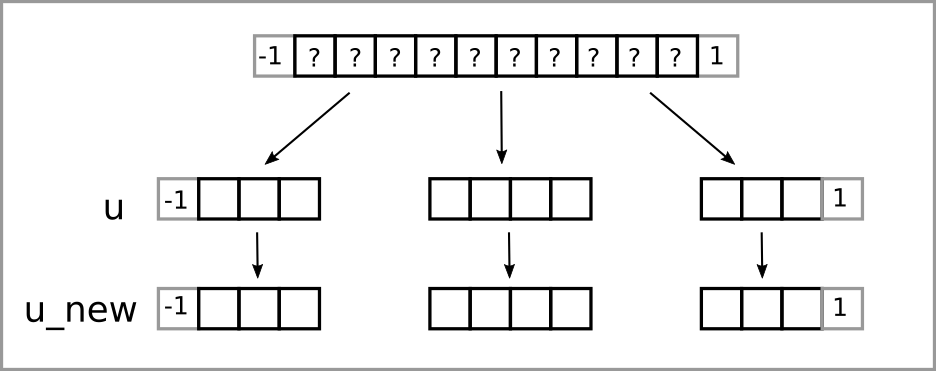
</div>
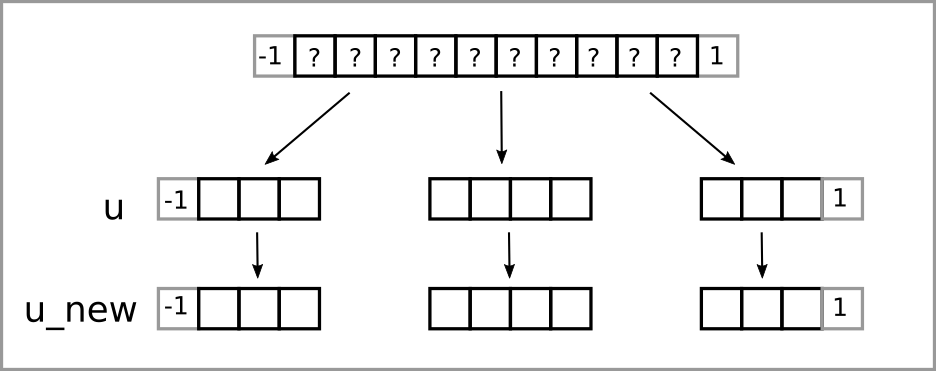

### Data dependencies

Recall the Jacobi update:

`u_new[i] = 0.5*(u[i-1]+u[i+1])`

Note that an entry in the interior of the locally stored vector can be updated using local data  only. For this one, communication is not needed.

<div>
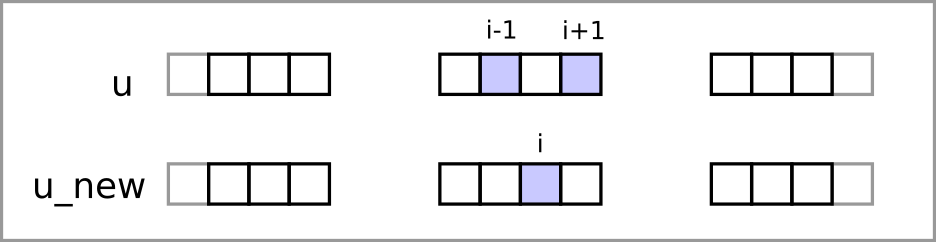
</div>
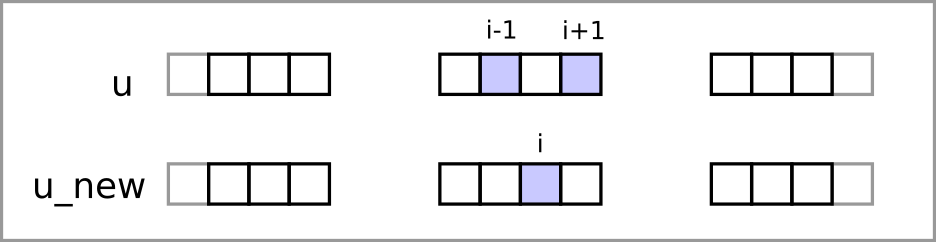

However, to update the entries on the boundary of the locally stored vector we need entries stored on other processors.

<div>
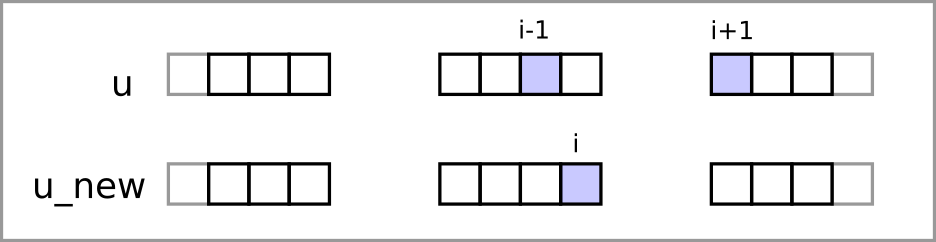
</div>
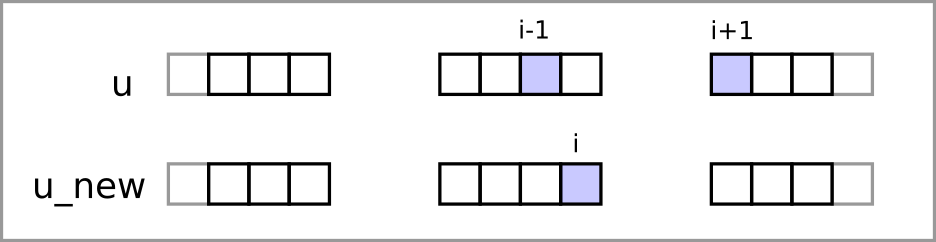

Thus, in order to update the local entries in `u_new`, we also need  some remote entries of vector `u` located in neighboring processes. Figure below shows the entries of `u` needed to update the local entries of `u_new` in a particular process (CPU 2).

<div>
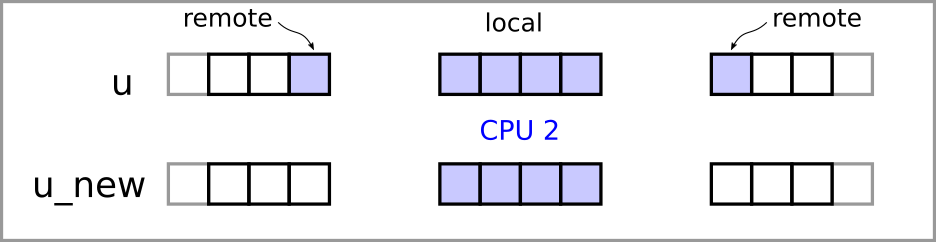
</div>
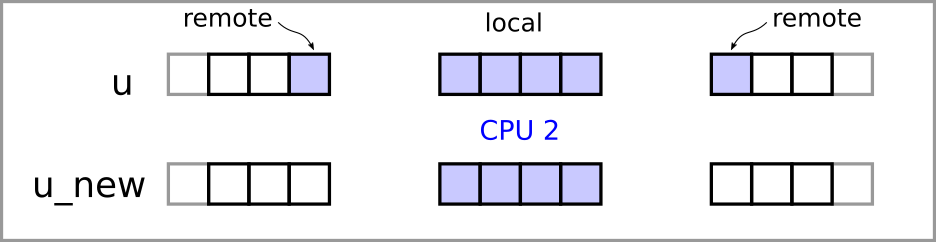

### Communication overhead
- We update $N/P$ entries in each process at each iteration, where $N$ is the total length of the vector and $P$ the number of processes
- Thus, computation complexity is $O(N/P)$
- We need to get remote entries from 2 neighbors (2 messages per iteration)
- We need to communicate 1 entry per message
- Thus, communication complexity is $O(1)$
- Communication/computation ration is $O(P/N)$, making the algorithm potentially scalable if $P<<N$.


### Ghost (aka halo) cells

A usual way of implementing the Jacobi method and related algorithms is using so-called ghost cells. Ghost cells represent the missing data dependencies in the data owned by each process. After importing the appropriate values from the neighbor processes one can perform the usual sequential Jacobi update locally in the processes.

<div>
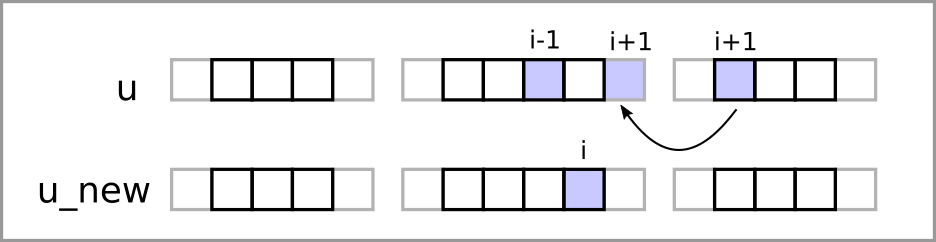
</div>
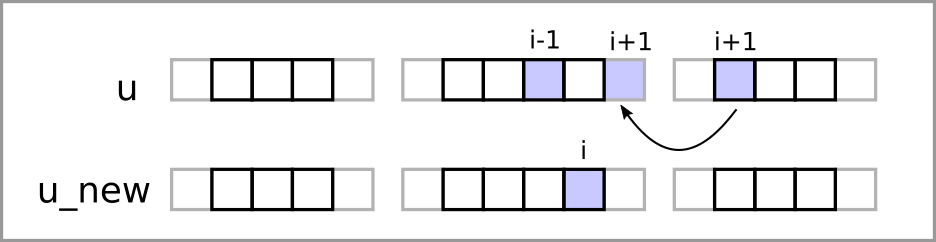

Thus, the algorithm is usually implemented following two main phases at each iteration Jacobi:

1. Fill the ghost entries with communications
2. Do the Jacobi update sequentially at each process

<div>
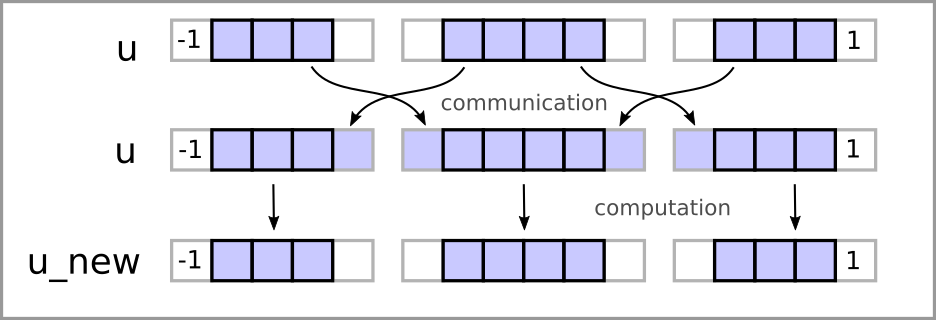
</div>
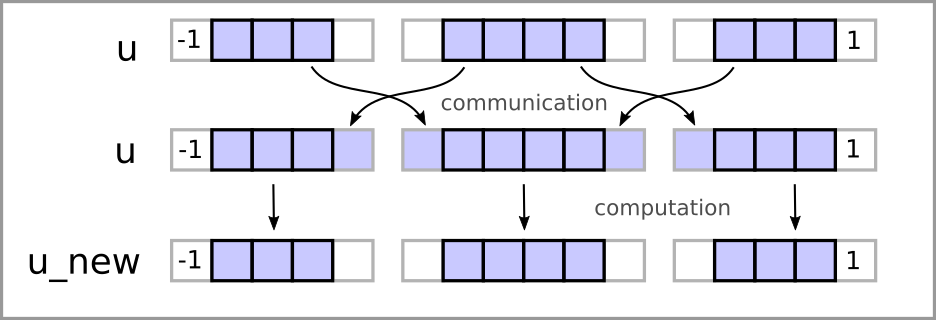

## MPI implementation

We consider the implementation using MPI. The programming model of MPI is generally better suited for data-parallel algorithms like this one than the task-based model provided by Distributed.jl. In any case, one can also implement it using Distributed.jl, but it requires some extra effort to setup the remote channels right for the communication between neighbor processes.
 
Take a look at the implementation below and try to understand it.


In [ ]:
] add MPI

In [ ]:
using MPI

In [ ]:
code = quote
    using MPI
    MPI.Init()
    function jacobi_mpi(n,niters)
        comm = MPI.COMM_WORLD
        nranks = MPI.Comm_size(comm)
        rank = MPI.Comm_rank(comm)
        if mod(n,nranks) != 0
            println("n must be a multiple of nranks")
            MPI.Abort(comm,1)
        end
        load = div(n,nranks)
        u = zeros(load+2)
        u[1] = -1
        u[end] = 1
        u_new = copy(u)
        for t in 1:niters
            # Communication
            if rank != 0
                neig_rank = rank-1
                s = 2
                r = 1
                MPI.Sendrecv!(view(u,s:s),view(u,r:r),comm;dest=neig_rank,source=neig_rank)
            end
            if rank != (nranks-1)
                neig_rank = rank+1
                s = load+1
                r = load+2
                MPI.Sendrecv!(view(u,s:s),view(u,r:r),comm;dest=neig_rank,source=neig_rank)
            end
            # Local computation
            for i in 2:(load+1)
                u_new[i] = 0.5*(u[i-1]+u[i+1])
            end
            u, u_new = u_new, u
        end
        # Gather the results
        if rank !=0
            lb = 2
            ub = load+1
            MPI.Send(view(u,lb:ub),comm,dest=0)
            u_all = zeros(0) # This will nevel be used
        else
            u_all = zeros(n+2)
            # Set boundary
            u_all[1] = -1
            u_all[end] = 1
            # Set data for rank 0
            lb = 2
            ub = load+1
            u_all[lb:ub] = view(u,lb:ub)
            # Set data for other ranks
            for other_rank in 1:(nranks-1)
                lb += load
                ub += load
                MPI.Recv!(view(u_all,lb:ub),comm;source=other_rank)
            end
        end
        return u_all
    end
    function jacobi(n,niters)
        u = zeros(n+2)
        u[1] = -1
        u[end] = 1
        u_new = copy(u)
        for t in 1:niters
            for i in 2:(n+1)
                u_new[i] = 0.5*(u[i-1]+u[i+1])
            end
            u, u_new = u_new, u
        end
        u
    end
    function testit(load)
        comm = MPI.COMM_WORLD
        nranks = MPI.Comm_size(comm)
        rank = MPI.Comm_rank(comm)
        n = load*nranks
        niters = 100
        u_par = jacobi_mpi(n,niters)
        if rank == 0
            # Compare agains serial
            u_seq = jacobi(n,niters)
            if u_par ≈ u_seq
                println("Test passed 🥳")
            else
                println("Test failed")
            end
        end
    end
    testit(3)
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

<div class="alert alert-block alert-success">
<b>Question:</b>  In function jacobi_mpi, how many messages per iteration are sent from a process away from the boundary (excluding the messages to collect the data on rank 0)?
</div>

    a) 1
    b) 2
    c) 3
    d) 4



In [ ]:
answer = "x" # replace x with a, b, c or d
jacobi_2_check(answer)

### Latency hiding

Can our implementation above be improved? Note that we only need communications to update the values at the boundary of the portion owned by each process. The other values (the one in green in the figure below) can be updated without communications. This provides the opportunity of overlapping the computation of the interior values (green cells in the figure) with the communication of the ghost values. This technique is called latency hiding, since we are hiding communication latency by overlapping it with computation that we need to do anyway.

The modification of the implementation above to include latency hiding is leaved as an exercise (see below).


<div>
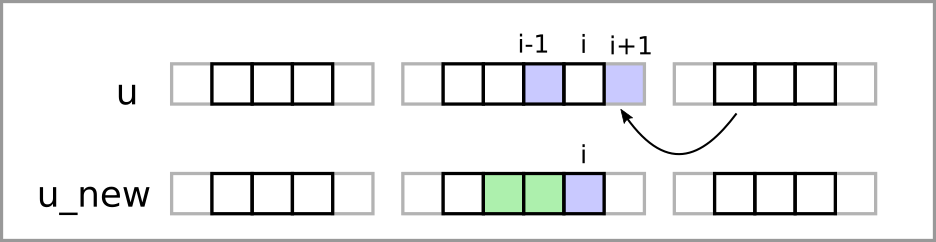
</div>

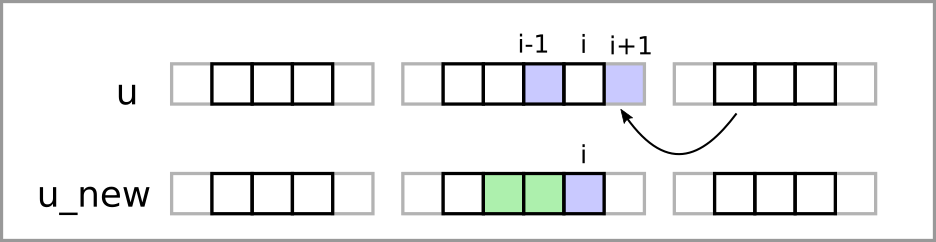

## Extension to 2D


Now, let us study the method for a 2D example.

<div>
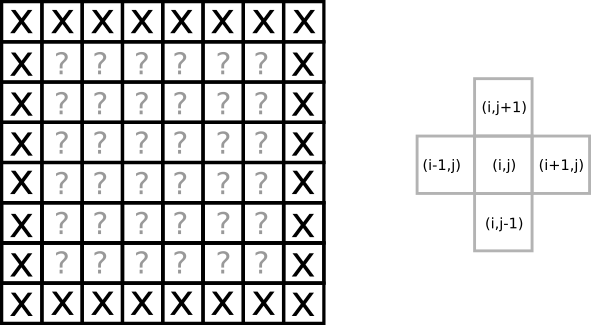
</div>
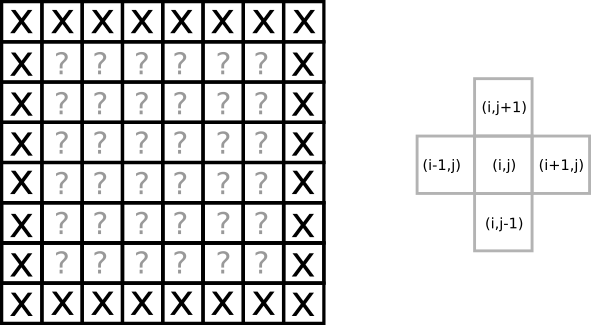

For the Laplace equation in 2D, the interior values in the computational grid (represented by a matrix $u$) are computed with this iterative scheme. The entry $(i,j)$ of  matrix $u$ at iteration $t+1$ is computed as:


$u^{t+1}_{(i,j)} = \dfrac{u^t_{(i-1,j)}+u^t_{(i+1,j)}+u^t_{(i,j-1)}+u^t_{(i,j+1)}}{4}$

Note that each entry is updated as the average of the four neighbors (top,bottom,left,right) of that entry in the previous iteration. 

### Serial implementation

The next code implements a simple example, where the boundary values are equal to 1.

In [ ]:
function jacobi_2d(n,niters)
    u = zeros(n+2,n+2)
    u[1,:] = u[end,:] = u[:,1] = u[:,end] .= 1
    u_new = copy(u)
    for t in 1:niters
        for j in 2:(n+1)
            for i in 2:(n+1)
                north = u[i,j+1]
                south = u[i,j-1]
                east = u[i+1,j]
                west = u[i-1,j]
                u_new[i,j] = 0.25*(north+south+east+west)
            end
        end
        u, u_new = u_new, u
    end
    u
end

In [ ]:
u = jacobi_2d(10,0)

### Where can we exploit parallelism?

```julia
for t in 1:niters
    for j in 2:(n+1)
        for i in 2:(n+1)
            north = u[i,j+1]
            south = u[i,j-1]
            east = u[i+1,j]
            west = u[i-1,j]
            u_new[i,j] = 0.25*(north+south+east+west)
        end
    end
    u, u_new = u_new, u
end
```

- The outer loop cannot be parallelized (like in the 1d case). 
- The two inner loops are trivially parallel


### Parallelization strategies

In 2d one has more flexibility in order to distribute the data over the processes. We consider these three alternatives:

- 1D block partition (each worker handles a subset of consecutive rows and all columns)
- 2D block partition (each worker handles a subset of consecutive rows and columns)
- 2D cyclic partition (each workers handles a subset of alternating rows ans columns)

The three partition types are depicted in the following figure for 4 processes.

<div>
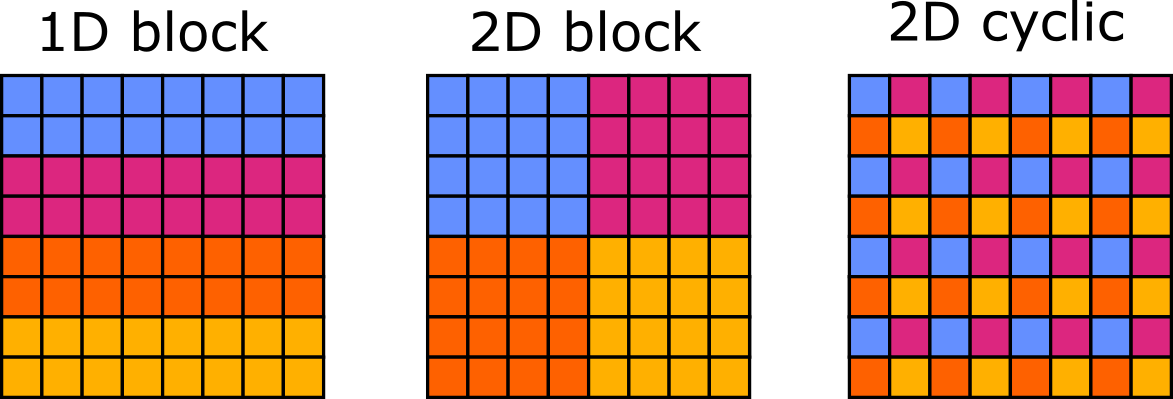
</div>
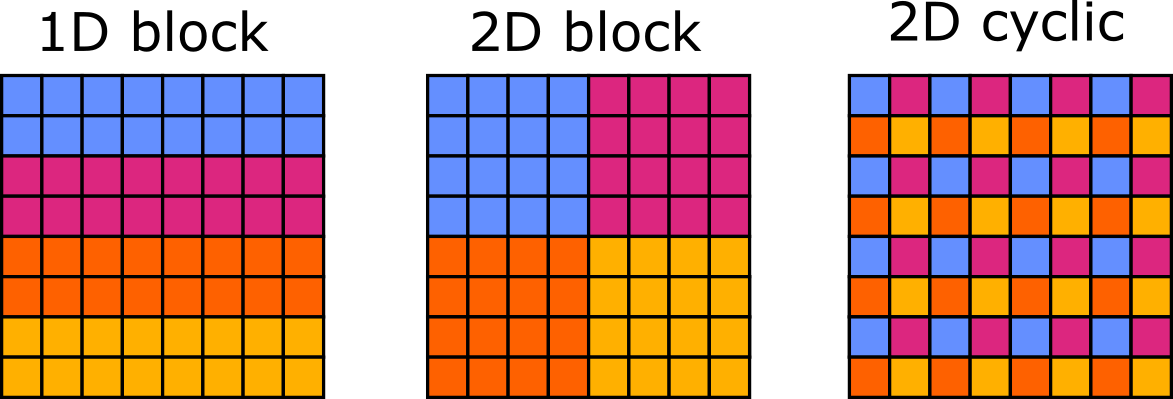

Which of the thee alternatives is more efficient? To answer this question we need to quantify how much data is processed and communicated in each case. The following analysis assumes that the grid is of $N$ by $N$ cells and that the number of processes is $P$.

### 1D block partition

The following figure shows the portion of vector `u_new` that is updated at each iteration by a particular process (CPU 3) left picture, and which entries of `u` are needed to update this data, right picture. We use analogous figures for the other partitions below.


<div>
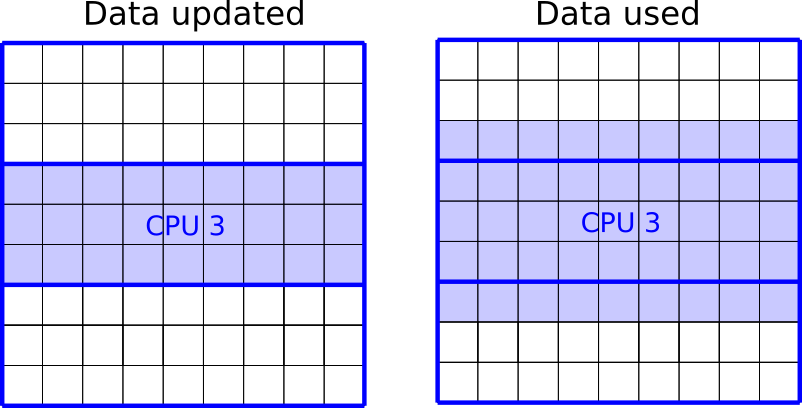
</div>
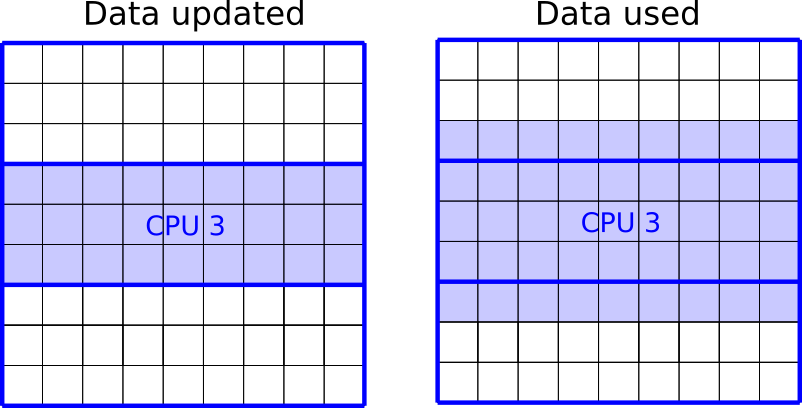

- We update $N^2/P$ items per iteration
- We need data from 2 neighbors (2 messages per iteration)
- We communicate $N$ items per message
- Communication/computation ratio is $2N/(N^2/P) = 2P/N =O(P/N)$

### 2D block partition

<div>
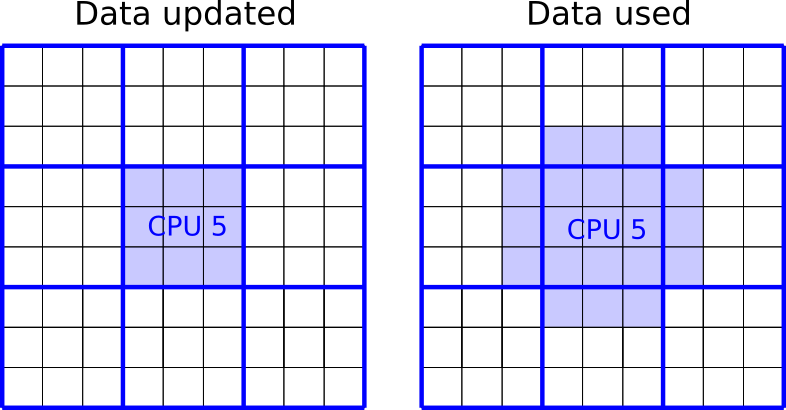
</div>

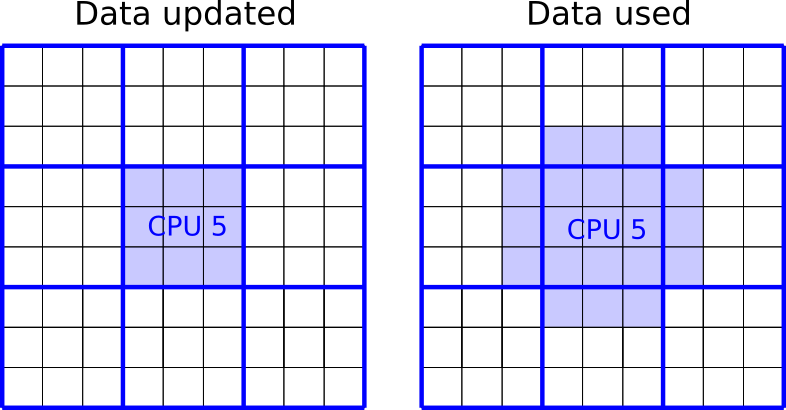

- We update $N^2/P$ items per iteration
- We need data from 4 neighbors (4 messages per iteration)
- We communicate $N/\sqrt{P}$ items per message
- Communication/computation ratio is $ (4N/\sqrt{P})/(N^2/P)= 4\sqrt{P}/N =O(\sqrt{P}/N)$

### 2D cyclic partition

<div>
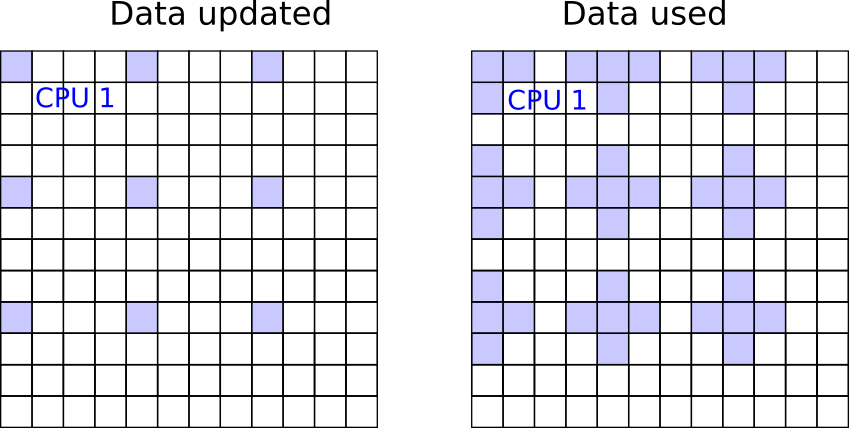
</div>
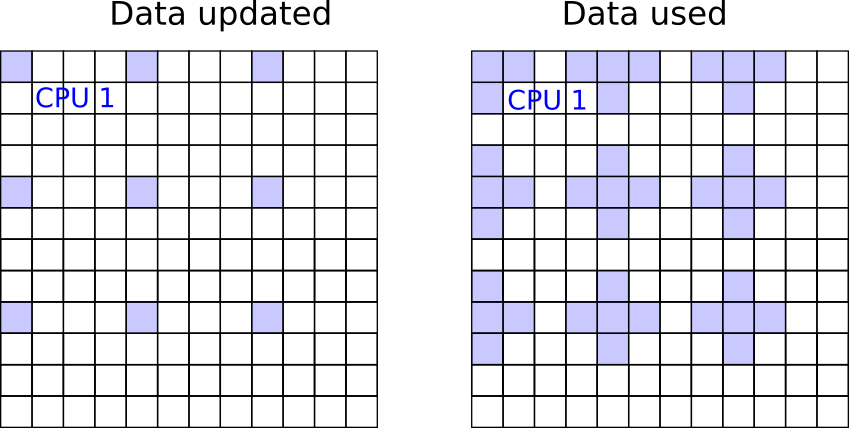

- We update $N^2/P$ items
- We need data from 4 neighbors (4 messages per iteration)
- We communicate $N^2/P$ items per message (the full data owned by the neighbor)
- Communication/computation ratio is $O(1)$

### Summary

|Partition | Messages <br> per iteration | Communication <br>per worker | Computation <br>per worker | Ratio communication/<br>computation |
|---|---|---|---|---|
| 1d block | 2 | O(N) | N²/P | O(P/N) |
| 2d block | 4 | O(N/√P) | N²/P | O(√P/N) |
| 2d cyclic | 4 |O(N²/P) | N²/P | O(1) |

### Which partition is the best one?



- Both 1d and 2d block partitions are potentially scalable if $P<<N$
- The 2d block partition has the lowest communication complexity
- The 1d block partition requires to send less messages (It can be useful if the fixed cost of sending a message is high)
- The best strategy for a given problem size will thus depend on the machine.
- Cyclic partitions are impractical for this application (but they are useful in others) 



## Exercises

### Exercise 1

Transform the parallel implementation of the 1d Jacobi method (function `jacopi_mpi`) to use latency hiding (overlap between computation of interior values and communication).

# License



This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.